# BigQuery Tutorial

## BigQuery Preprocessing

In [1]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np

# Adding project ID from Google Cloud Platform
PROJECT_ID = 'tdsbigquery'
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('tds_tutorial', exists_ok=True)

In [2]:
# Creating a reference of our table
table = client.get_table("bigquery-public-data.openaq.global_air_quality")

# Looking at the first five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


In [3]:
# Checking the number of measure station in each country
query = """SELECT country, COUNT(location) AS number_of_locations
                FROM `bigquery-public-data.openaq.global_air_quality`
                GROUP BY country
                ORDER by number_of_locations DESC"""

query_job = client.query(query)
query_job.to_dataframe().head(10)

,country,number_of_locations
0,CN,6402
1,US,3597
2,ES,2089
3,FR,1593
4,DE,1441
5,IN,1282
6,PL,836
7,AT,782
8,TR,495
9,TW,459


In [4]:
# Statistics Summary
query = """SELECT value,averaged_over_in_hours
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE unit = 'µg/m³'
            """
query_job = client.query(query)
query_job.to_dataframe().describe()

,value,averaged_over_in_hours
count,21236.000000,19951.000000
mean,114.253887,1.645882
std,6171.898244,4.073241
min,-335582.000000,0.250000
25%,2.300000,1.000000
50%,13.100000,1.000000
75%,44.000000,1.000000
max,825736.000000,59.000000


In [5]:
# Calculating the average value of of Ozone Gas in each different country
query = """
    SELECT
        country, 
        avg(value) as avg_value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'o3'
      AND country != 'NL'
      AND country != 'DK'
      AND country != 'LT'
      AND country != 'LU'
      AND unit = 'µg/m³'
    GROUP BY country
    ORDER BY avg_value ASC
        """

query_job = client.query(query)
query_df = query_job.to_dataframe()
query_df.head()

,country,avg_value
0,DE,1.442474
1,ES,1.455877
2,IE,6.701818
3,BE,8.860000
4,PE,17.657000


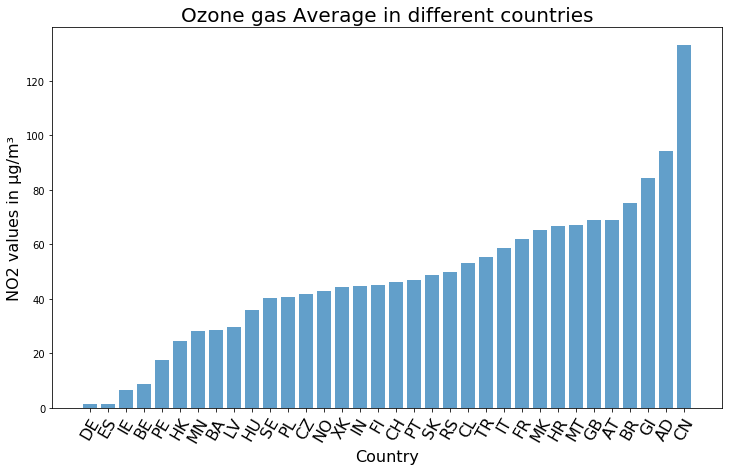

In [6]:
plt.subplots(figsize=(12,7))
y_pos = np.arange(len(query_df.country))
plt.bar(y_pos, query_df.avg_value, align='center', alpha=0.7)
plt.xticks(y_pos, query_df.country.values)

plt.ylabel('NO2 values in µg/m³', fontsize=16)
plt.xticks(rotation= 60,fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.title('Ozone gas Average in different countries', fontsize=20)
plt.show()

## BigQuery ML

In [7]:
from google.cloud.bigquery import magics
from kaggle.gcp import KaggleKernelCredentials
magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID
%load_ext google.cloud.bigquery

In [8]:
%%bigquery
CREATE MODEL IF NOT EXISTS `tds_tutorial.Model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  country AS label, latitude, longitude, value 
FROM
  `bigquery-public-data.openaq.global_air_quality`
LIMIT 800;

""


In [9]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `tds_tutorial.Model`)
ORDER BY iteration 

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.620431,0.620283,0.2,15349
1,0,1,0.503955,0.503675,0.4,6337
2,0,2,0.350776,0.350753,0.8,4062
3,0,3,0.201201,0.201948,1.6,5798
4,0,4,0.099076,0.100353,3.2,17729
5,0,5,0.046695,0.047973,6.4,7678
6,0,6,0.022370,0.023383,12.8,3873
7,0,7,0.010939,0.011649,25.6,3995
8,0,8,0.005421,0.005881,51.2,6840
9,0,9,0.002706,0.002989,102.4,4302


In [10]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `tds_tutorial.Model`, (
SELECT
  country AS label, latitude, longitude, value 
FROM
  `bigquery-public-data.openaq.global_air_quality`
LIMIT 800))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,1.0,1.0,1.0,0.000003,1.002001
